# Customer Churn Prediction

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
import joblib

In [73]:
df = pd.read_csv("../data/telco_customer_churn.csv")

In [74]:
df.shape
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   int64 
 3   Partner           7043 non-null   object
 4   Dependents        7043 non-null   object
 5   tenure            7043 non-null   int64 
 6   PhoneService      7043 non-null   object
 7   MultipleLines     7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  Contract          7043 non-null   object
 16  PaperlessBilling  7043 non-null   object
 17  PaymentMethod 

Basic Cleaning

In [75]:
df.columns = df.columns.str.strip()

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

Target Split

In [76]:
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn']

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [col for col in X.columns if col not in numeric_features]

numeric_features, categorical_features

(['tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'])

In [77]:
for col in numeric_features:
    X[col] = pd.to_numeric(X[col], errors='coerce')

X[numeric_features].isna().sum()

tenure               0
MonthlyCharges    7043
TotalCharges      7043
dtype: int64

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Preprocessing Pipelines

In [79]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Modeling Pipeline

In [80]:
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

log_reg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('model', LogisticRegression(max_iter=1000))])

Train Model

In [81]:
log_reg.fit(X_train, y_train)

/home/ubuntuforqtmhub/.local/lib/python3.8/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [82]:
joblib.dump(log_reg, '../app/pipeline.pkl')

['../app/pipeline.pkl']

Evaluate Model

In [83]:
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

ROC-AUC: 0.8393874809475832


/home/ubuntuforqtmhub/.local/lib/python3.8/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/home/ubuntuforqtmhub/.local/lib/python3.8/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['MonthlyCharges' 'TotalCharges']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


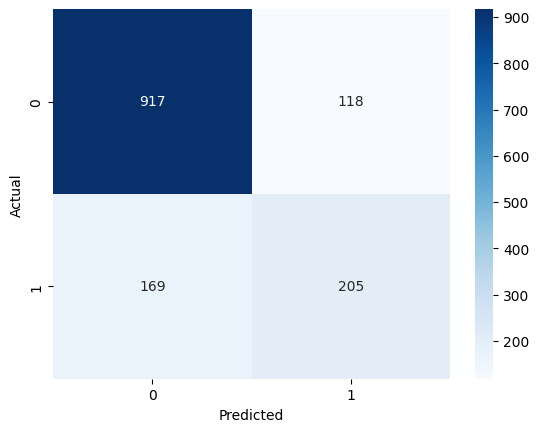

In [84]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [85]:
coefficients = log_reg.named_steps['model'].coef_[0]
feature_names = log_reg.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients}).sort_values(by='coefficient', ascending=False)
print(importance_df)

                                         feature  coefficient
35                  cat__Contract_Month-to-month     0.680477
15              cat__InternetService_Fiber optic     0.511384
42           cat__PaymentMethod_Electronic check     0.269990
17                        cat__OnlineSecurity_No     0.251128
26                           cat__TechSupport_No     0.224879
31                          cat__StreamingTV_Yes     0.194852
34                      cat__StreamingMovies_Yes     0.194556
39                     cat__PaperlessBilling_Yes     0.184679
20                          cat__OnlineBackup_No     0.119780
13                        cat__MultipleLines_Yes     0.119689
7                             cat__Dependents_No     0.117945
9                           cat__PhoneService_No     0.085498
12           cat__MultipleLines_No phone service     0.085498
4                           cat__SeniorCitizen_1     0.071727
23                      cat__DeviceProtection_No     0.055121
25      

In [86]:
top_positive = importance_df.sort_values(by='coefficient', ascending=False).head(10)
top_negative = importance_df.sort_values(by='coefficient', ascending=True).head(10)

top_features = pd.concat([top_negative, top_positive])
top_features = top_features.reset_index(drop=True)

# Top Features Influencing Customer Churn

/tmp/ipykernel_207/3577429362.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


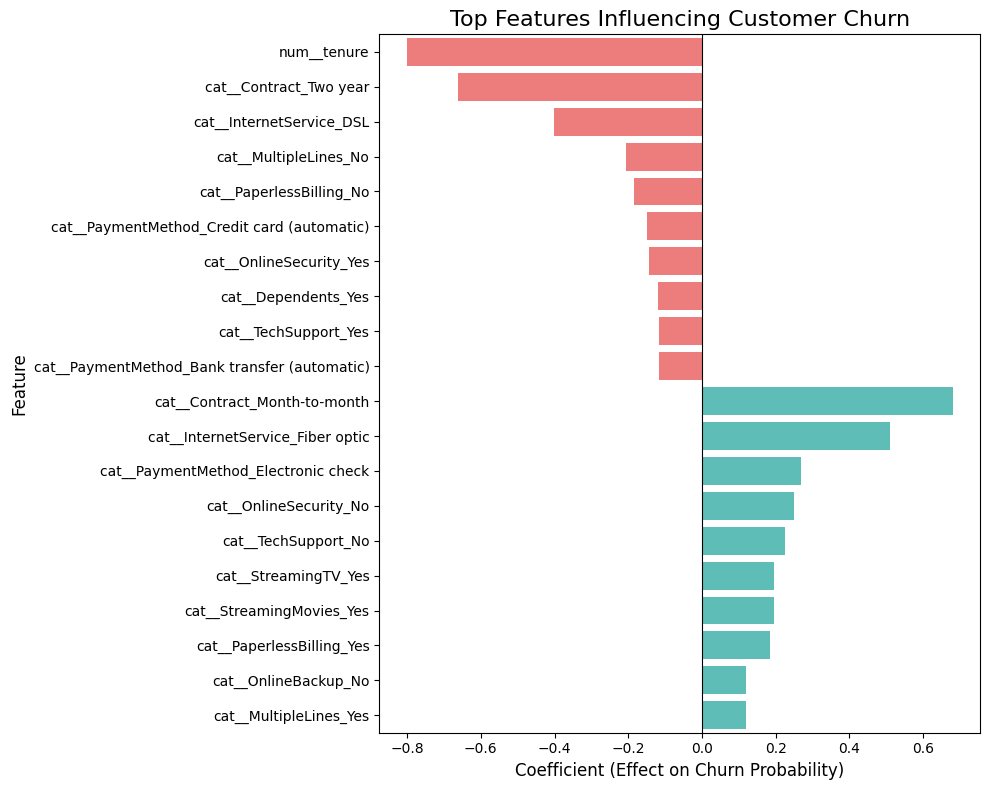

In [87]:
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_features,
    x='coefficient',
    y='feature',
    palette=['#FF6B6B' if x < 0 else '#4ECDC4' for x in top_features['coefficient']]
)

plt.title('Top Features Influencing Customer Churn', fontsize=16)
plt.xlabel('Coefficient (Effect on Churn Probability)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(0, color='black', linewidth=0.8)  # Center line
plt.tight_layout()
plt.show()